https://earthquake.usgs.gov/earthquakes/search/

In [11]:
from datetime import datetime

import matplotlib.pyplot as plt

from parser.app import ClickHouseParser, CsvParser
from parser.db import client
from parser.repo import handler
from parser.repo.driver import create_tables, drop_tables

In [ ]:
start = datetime(2000,3,6)
end = datetime(2023,6,15)

parser = CsvParser(start, end, 'world', 'World_2000-2023')
parser.to_csv()

# Работа с таблицами

In [47]:
create_tables()

In [46]:
drop_tables()

In [4]:
result = handler.show_tables()
print(result)

ip_geo
quakes


# Загрузка данных в БД

In [48]:
start = datetime(2000,3,6)
end = datetime(2023,6,15)

parser = ClickHouseParser(start, end, 'russia')

start (datetime.datetime(2000, 3, 6, 0, 0), datetime.datetime(2000, 12, 31, 0, 0)) period, with area russia
2000-03-06 00:00:00 params=RequestParam(format='geojson', starttime='2023-06-18', endtime='2023-06-20', minlatitude='41.162', maxlatitude='81.957', minlongitude='19.688', maxlongitude='190.547', minmagnitude='2.5') timeout=10.0 endpoint='https://earthquake.usgs.gov/fdsnws/event/1/query' {'minlatitude': '41.162', 'maxlatitude': '81.957', 'minlongitude': '19.688', 'maxlongitude': '190.547'}
start (datetime.datetime(2001, 1, 1, 0, 0), datetime.datetime(2001, 12, 31, 0, 0)) period, with area russia
2001-01-01 00:00:00 params=RequestParam(format='geojson', starttime='2023-06-18', endtime='2023-06-20', minlatitude='41.162', maxlatitude='81.957', minlongitude='19.688', maxlongitude='190.547', minmagnitude='2.5') timeout=10.0 endpoint='https://earthquake.usgs.gov/fdsnws/event/1/query' {'minlatitude': '41.162', 'maxlatitude': '81.957', 'minlongitude': '19.688', 'maxlongitude': '190.547'}


In [49]:
parser.upload_quakes()

None


# Извлечение и анализ данных

In [50]:
tmp_df = client.query_df('SELECT * FROM quakes ORDER BY Date')

In [ ]:
tmp_df.describe()

In [51]:
spectr = tmp_df.columns.to_list()[4:]

In [26]:
magnitude = tmp_df['Mercury_sun_distance'].values.tolist()
dates = tmp_df['Date'].values.tolist()

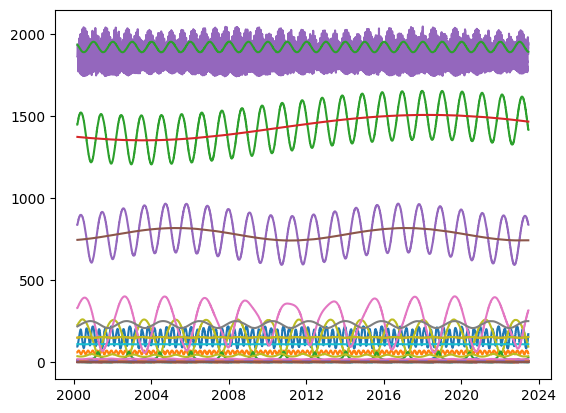

In [52]:
dates = tmp_df['Date'].values.tolist()
for col in spectr:
    plt.plot(dates, tmp_df[col].values.tolist())
plt.show()

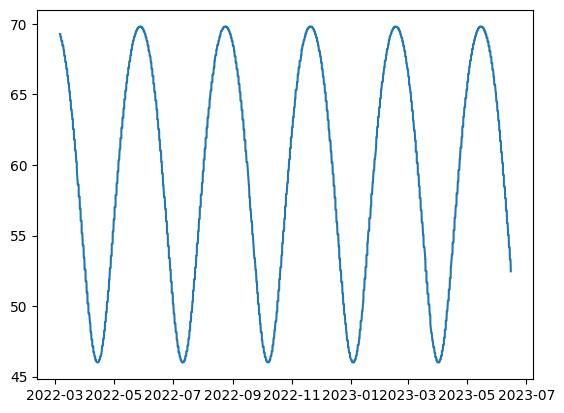

In [27]:
plt.plot(dates, magnitude)
plt.show()

In [53]:
tmp_query = client.query_df("""
SELECT toDate(Date), count(toDate(Date)), max(Magnitude), min(Magnitude), divide(avg(Mercury_earth_distance), 30)
FROM quakes
GROUP BY toDate(Date)
ORDER BY toDate(Date)
""")

In [54]:
tmp_query

,toDate(Date),count(toDate(Date)),max(Magnitude),min(Magnitude),"divide(avg(Mercury_earth_distance), 30)"
0,2000-03-06,2,4.3,3.7,3.123075
1,2000-03-08,2,4.0,3.5,3.165479
2,2000-03-09,1,4.4,4.4,3.197509
3,2000-03-10,4,5.0,4.1,3.235192
4,2000-03-11,1,4.0,4.0,3.278578
...,...,...,...,...,...
8252,2023-06-11,18,6.2,2.5,5.264545
8253,2023-06-12,10,4.0,2.6,5.366050
8254,2023-06-13,11,4.3,2.5,5.461614
8255,2023-06-14,10,5.3,2.5,5.508962


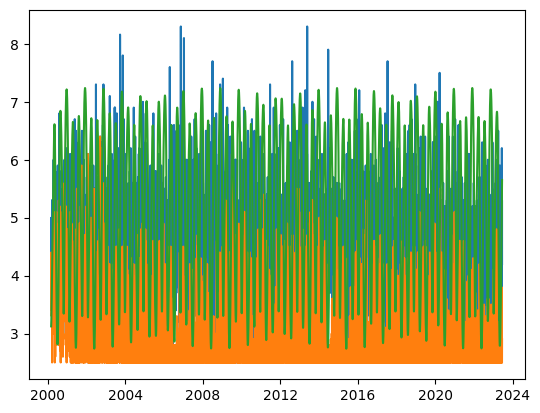

In [55]:
max_mag = tmp_query['max(Magnitude)'].values.tolist()
min_mag = tmp_query['min(Magnitude)'].values.tolist()
merc =  tmp_query['divide(avg(Mercury_earth_distance), 30)'].values.tolist()
dates = tmp_query['toDate(Date)'].values.tolist()


plt.plot(dates, max_mag)
plt.plot(dates, min_mag)
plt.plot(dates, merc)
plt.show()